# Title: <hr> Introduction

400 word introduction for the topic with 2 cited studies

200 word introduction for the 

<hr>

# Methods & Results

To do an exploratory analysis of our data set and answer our predictive question, our group decided to do a knn classification. By doing so we are able to determine the best number of neighbors that should be used to result in the most accurate categorical prediction for Mine or Rock. We began by loading our data from the original [source](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)) from the internet and reading the data frame in Juptyer. The data was already cleaned and did not require wrangling or cleaning for the model. We only wrangled the data for the purposes of exploratory analysis but the original data frame was used for training and testing. Furthermore the data was also standardized.

Note: We did need to change the attribute names to be of fixed length for the frequency bands as otherwise when plotting, the ggplot library arranges the variables to be in alphabetical order. We determined that renaming the attribute names would not affect the model, but will help in visualization.

The next step in our analysis was to randomly split the data into a training and testing set. This allowed us to work with 75% of the data set (training) without being biased. We could then compare our results to the remaining 25% of the data set (testing) that was not manipulated. The training data was then displayed in a scatterplot matrix to show correlations.

A crucial step that we took was to set the seed to be a fixed number, so that our work is reproducible.

First we created a model specification with engine ‘kknn’ and mode “classification”. The data then underwent a 5 fold cross validation. This ensures a more accurate representation of the training data and the randomness does not negatively affect our model. We then created a recipe and processed the data so it was centered and scaled. This is important to ensure all variables have equal weighting on the final prediction.
Note: Although our data was already scalled we still needed to center it.
Finally the model was tuned and the accuracy was collected. We then created a line graph using ggplot of the accuracy of the training data to determine the best number of neighbors which is 1. Using this number of neighbors we created a new model and trained it. Then, we tested the model using test data that we had intially split(25% of original dataset). We calculated the accuracy of our model on test data to know if our model would generalized well to unseen data. Finally, we produced a confusion matrix to evaluate our analysis.

### loading the necessary libraries

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
SEED <- 787

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading the data from Web

In [2]:
column_names<-c('X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
                'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
                'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
                'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
                'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
                'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59','X60', 'type')
sonar_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
                        col_names = column_names) |>
              mutate(type = as.factor(type),
                     obs = 1:n())

Rows: 208 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): type
dbl (60): X01, X02, X03, X04, X05, X06, X07, X08, X09, X10, X11, X12, X13, X...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Exploratory Analysis
Here we plot various frequency bands against magnitude(Standardized) and groupped by their respective observations. The obsevations are coloured by the type: rock or mine. We will also set alpha value for the line graph to be 0.4 to avoid overplotting.

[1] "[Plot. 1] Overlayed frequency diagram"


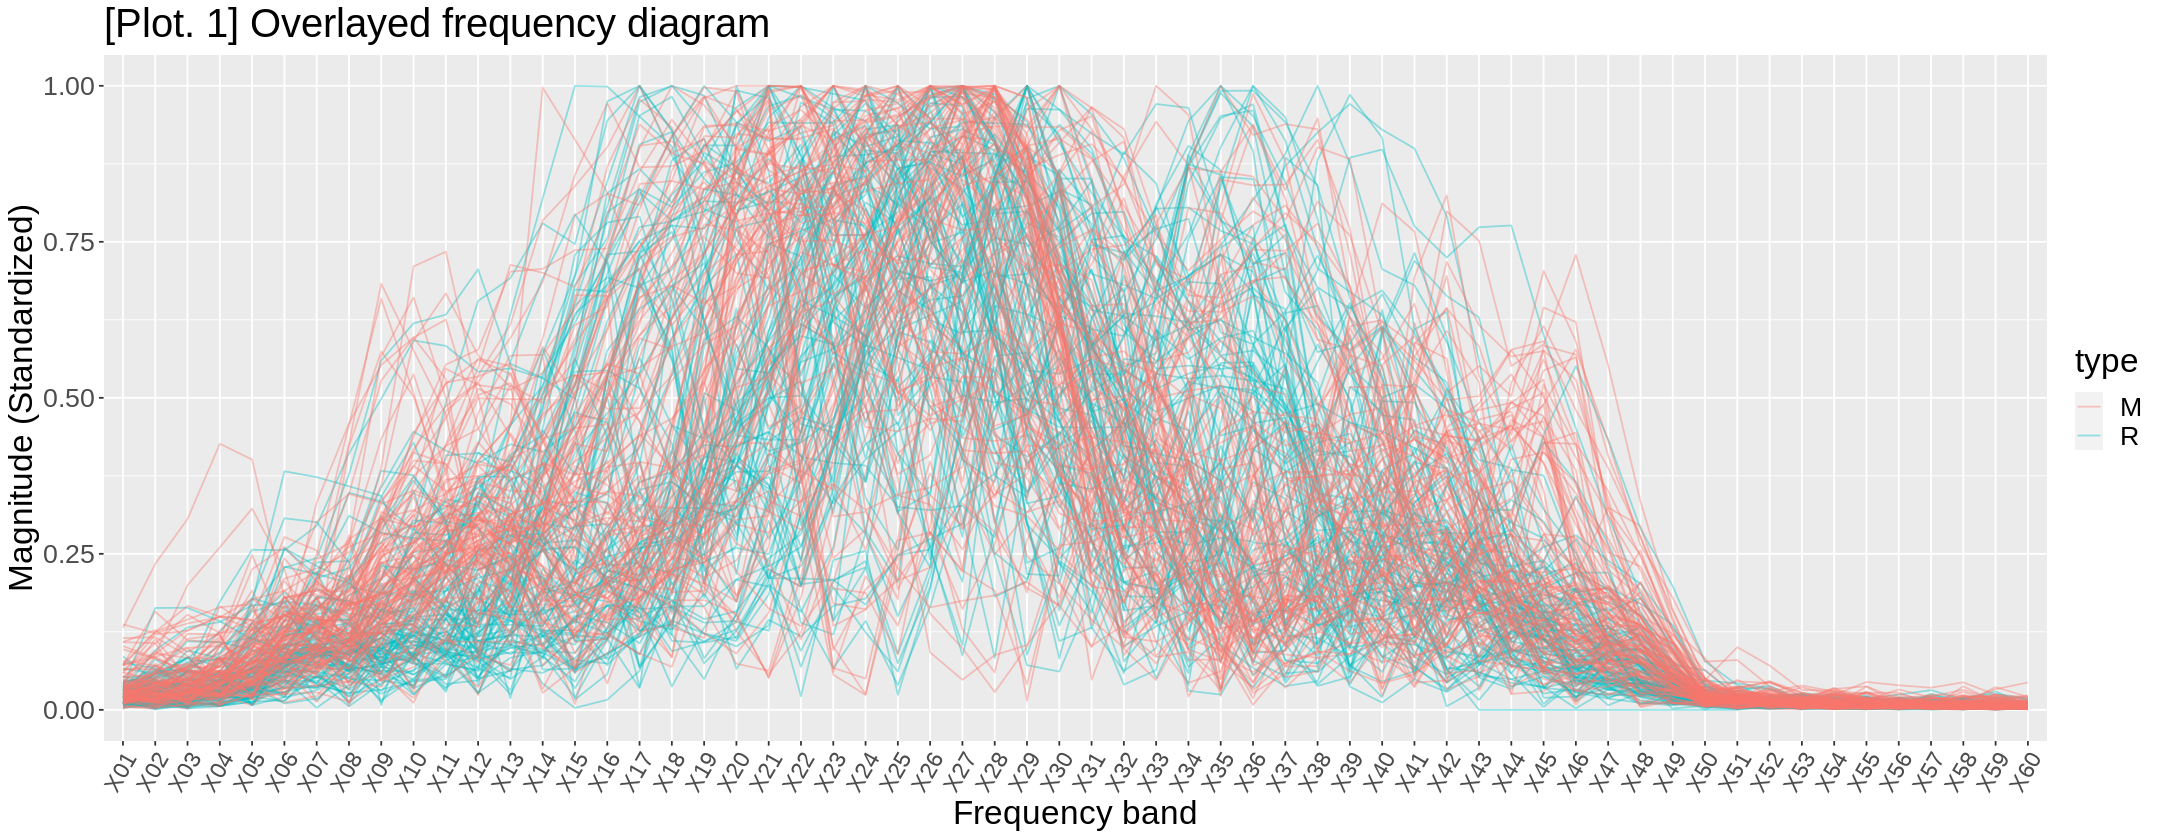

In [3]:
options(repr.plot.width=18,repr.plot.height=7)
sonar_data_long <- pivot_longer(sonar_data,
                                cols = X01:X60,
                                values_to = "magnitude",
                                names_to  = "time")

exp_plot <- ggplot(sonar_data_long, aes(x = time, y = magnitude)) +
            geom_line(aes(color = type, group = obs), alpha=0.4) +
            theme(text=element_text(size=20),
                  axis.text.x = element_text(angle = 60, vjust = 1, hjust=1, size = 14)) +
            labs(x="Frequency band",
                 y="Magnitude (Standardized)",
                 label="Type") +
            ggtitle("[Plot. 1] Overlayed frequency diagram")
exp_plot
print("[Plot. 1] Overlayed frequency diagram")

From analyzing the above graph, there seems to be no obvious distinction in the signature of frequency bands for mine or rock.

### Splitting Data
As stated before we will be splitting our data in 2 parts, 75% for training data nad 25% for testing data.

In [4]:
set.seed(SEED)
sonar_split <- initial_split(sonar_data, prop = 0.75, strata = type)
sonar_train <- training(sonar_split)
sonar_test <- testing(sonar_split) 

### Making the recipe and model specification
We will not touch the testing data(`sonar_test`) till our model is completly ready. We first create a recipe and then a model spec using the kknn engine and classification mode. Since we are not sure how many neighbors would be best for the prediction, we will tune it.

In [5]:
sonar_recipe <- recipe(type ~ ., data = sonar_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

sonar_initial_spec <- nearest_neighbor(weight_func="rectangular",neighbors = tune()) |>
                      set_engine("kknn") |>
                      set_mode("classification")

### Cross-validation on k=1 to k=30
We perform a 5 fold corss validation and then train the model by supplying, recipe, model spec and vfolds. We alos collect the statistics about the model's performance for the values of k tested.

In [6]:
set.seed(SEED)
sonar_vfold <-  vfold_cv(sonar_train, strata = type,v = 5)

ks <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
  add_recipe(sonar_recipe) |>
  add_model(sonar_initial_spec) |>
  tune_grid(resamples = sonar_vfold, grid = ks) |>
  collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8970968,5,0.01822403,Preprocessor1_Model01
1,roc_auc,binary,0.8959244,5,0.01806487,Preprocessor1_Model01
2,accuracy,binary,0.8970968,5,0.01822403,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,roc_auc,binary,0.9143925,5,0.01884404,Preprocessor1_Model29
30,accuracy,binary,0.8196237,5,0.01141059,Preprocessor1_Model30
30,roc_auc,binary,0.9119590,5,0.01995487,Preprocessor1_Model30


### Plotting the the model accuracy against k
Since It is difficult to find a good value of k just by looking at the table above, we can plot the mean against k and find the best value of k for our model.

[1] "PLot title"


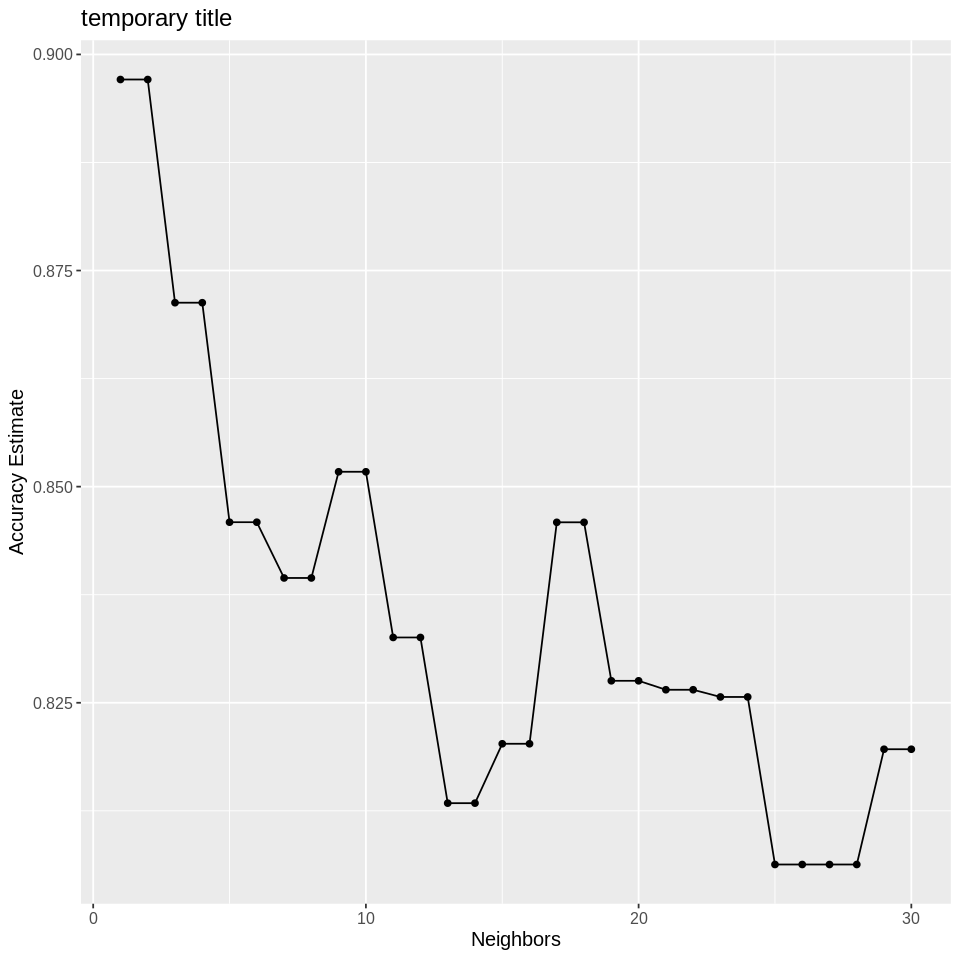

In [7]:
set.seed(SEED)
options(repr.plot.height = 8, repr.plot.width = 8)
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k_lots <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
    ggtitle("temporary title")

print("PLot title")
accuracy_vs_k_lots

### Finding the best k
we can choose the k value from the above graph which would be 1, or we could extract it from the data frame as shown below.

In [8]:
best_k_stats <- accuracies |>
                arrange(desc(mean)) |>
                slice(1)
best_k_stats

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8970968,5,0.01822403,Preprocessor1_Model01


### Building model with the Best k
Now we extract the best value of neighbors from the above data frame and use it to create a new model specification. Finall we fit the training data with the recipe and new model spec.

In [10]:
set.seed(SEED)
k <- select(best_k_stats,neighbors) |>
     pull()

best_knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors = k) |>
                 set_engine("kknn") |>
                 set_mode("classification")

best_fit <- workflow() |>
  add_recipe(sonar_recipe) |>
  add_model(best_knn_spec) |>
  fit(data = sonar_train)

best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(1,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05806452
Best kernel: rectangular
Best k: 1

### Predicting on test data
We use the above fit to predict the type of our testing data. Then we calculate the RMSPE of our model.

In [11]:
sonar_test_predictions <- predict(best_fit, sonar_test) |>
  bind_cols(sonar_test)


sonar_test_predictions |>
  metrics(truth = type, estimate = .pred_class) |>
  filter(.metric == "accuracy")
print("table title")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9245283


[1] "table title"


### Confusion Matrix
Finally to asses the accuracy in terms of raw data, we can create a confusion matrix.

In [12]:
confusion <- sonar_test_predictions |>
             conf_mat(truth = type, estimate = .pred_class)
confusion
print("table title")

          Truth
Prediction  M  R
         M 26  2
         R  2 23

[1] "table title"


<hr>

# Discussion

Our project found out the best value for the number of neighbors for a knn classification model of the sonar data is 1. Our model had a RMSE of 90.9% which when compared to RMSPE of 92.45% suggests that the model will generalize well over unseen data. The impacts of these findings can be used to determine if an object is a rock or a mine. This could be useful for ships and submarines when traveling in a hostile territory, for example a war zone. A more accurate version of the model found in this study could be used in rescue vessels. Questions for future study could be to determine the size, distance or depth of a mine.
<hr>

# References

citation from intro + citation for data